In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from copy import deepcopy
from scipy.optimize import curve_fit

import time
import os
import sys
import scipy as sp
import json
from scipy.fft import fft, fftfreq

import qutip as qt
import matplotlib.style as style

from Tomography.TomoAnalysis_simplified import TomoAnalysis

mplstyle_path = os.path.join(os.getcwd(), 'prx.mplstyle')
style.use(mplstyle_path)

In [3]:
tomo_qubits = [0, 2, 3]

In [4]:
z = 1.96 # student's number for the error bars of 95% confidence

In [5]:
def ceil_decimal(array, decimals=0):
  """Rounds up the elements of a NumPy array to the specified decimal place.

  Args:
    array: The NumPy array to round up.
    decimals: The number of decimal places to round to (default: 0).

  Returns:
    A new NumPy array with the rounded up values.
  """
  factor = 10**decimals
  return np.ceil(array * factor) / factor

# Save paths

Change as necessary.

In [6]:
save_plot_path = os.getcwd()
print("Will save all plots to", save_plot_path)

Will save all plots to s:\Connie\experiments\qram_tprocv1_expts\data_plot


# Formatting

In [7]:
color_switch = '#ff7f50'
color_input = '#468499'
color_q2 = '#E16F8F'
color_basis = '#66CDAA'

def CQ_from_init(init_state):
    _init_state = init_state.replace('|', '')
    q0, q1 = _init_state[:-1].split('>')
    if q0 == '0+1' or q0=='0+i':
        if q1 != '0+1' and q1 !='0+i':
            return 'QrCi'
        return 'QrQi'

    else: 
        if q1 == '0+1' or q1=='0+i':
            return 'CrQi'
        return 'CrCi'

def color_from_cq(cq):
    if cq == 'QrCi':
        return color_switch
    elif cq == 'QrQi':
        return color_q2
    elif cq == 'CrQi':
        return color_input
    elif cq == 'CrCi':
        return color_basis

def latex_from_cq(cq):
    return cq


# Import 2q tomo

Retrieve saved initial state density matrices from 2q tomography measurement.

In [8]:
rho_MLE_ZZ_2Q_filepath = os.path.join(os.getcwd(), 'Tomography', '202502111059_init_rhoMLE_ZZ_2Q_01.npz')

print(f'Using rho_MLE_ZZ for Q0/Q1 from file {rho_MLE_ZZ_2Q_filepath}')

rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ_dict retrieved with init_states {rho_MLE_ZZ_dict.keys()}')

Using rho_MLE_ZZ for Q0/Q1 from file s:\Connie\experiments\qram_tprocv1_expts\data_plot\Tomography\202502111059_init_rhoMLE_ZZ_2Q_01.npz
rho_MLE_ZZ_dict retrieved with init_states dict_keys(['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>'])


# Helper functions to calculate ideal final states

In [9]:
tomo_analysis = TomoAnalysis(nb_qubits=3)
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(tomo_analysis.calib_order_numeric):
    psis.update({label_numeric:tomo_analysis.psi_basis['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
def get_qram_qSLR_state_from_rho(init_rho_SI, post_select=False, post_select_state=None):
    """
    init_rho_SI should be a np array
    """
    # in order |00>, |01>, |10>, |11> for Q0 (switch), Q1 (input)
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.shape(init_rho_SI) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    # print('constructing final state on |switch, out1, out2>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_SI[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    return rho_final_SLR.unit()

# Helper function to get the best Z rotation from a fid grid

In [10]:
def get_best_phis(fids_grids, phis, init_states, check_init_states=None, plot_fid_grids=False, verbose=True):
    if check_init_states is None: check_init_states = init_states
    fids_grids_reshaped = []
    for i_state in range(len(init_states)):
        grid_shape = fids_grids[i_state].shape
        # print(grid_shape)
        fids_grid = np.copy(fids_grids[i_state]).tolist()
        # print(init_states[i_state], grid_shape)
        if grid_shape[0] == 1:
            for i in range(grid_shape[1]-1):
                fids_grid.append(fids_grid[0])
        # print(np.array(fids_grid).shape)
        fids_grids_reshaped.append(fids_grid)

    fids_grids_reshaped = np.array(fids_grids_reshaped)
    print(fids_grids_reshaped.shape)

    best_avg_fid = 0
    best_fids = []
    best_phis = [0, 0, 0]
    best_phi_indices = [0, 0, 0]
    individual_best_fids = np.zeros((len(init_states)))
    individual_best_phis = np.zeros((len(init_states), 3))
    for iphi0, phi0 in enumerate(phis[0]):
        for iphi1, phi1 in enumerate(phis[1]):
            for iphi2, phi2 in enumerate(phis[2]):
                avg_fid = 0
                for i_state, init_state in enumerate(init_states):
                    if init_state not in check_init_states: continue
                    fid = fids_grids_reshaped[i_state][iphi0, iphi1, iphi2]
                    avg_fid += fid
                    if fid > individual_best_fids[i_state]:
                        individual_best_fids[i_state] = fid
                        individual_best_phis[i_state] = [phi0, phi1, phi2]
                avg_fid /= len(check_init_states)
                if avg_fid > best_avg_fid:
                    best_phis = [phi0, phi1, phi2]
                    best_phi_indices = [iphi0, iphi1, iphi2]
                    best_avg_fid = avg_fid

    inner_sweep = phis[2]
    outer_sweep = phis[1]
    y_sweep = outer_sweep
    x_sweep = inner_sweep
    
    if plot_fid_grids:
        vmax = 1.0
        for i_state in range(len(init_states)):
            # print(init_states[i_state])
            # print(f'best phi Q0 {best_phis[0]}')
            plt.figure()
            # plt.title(f'Fidelities {init_states[i_state]} ($\phi_0: ${best_phis[0]:0.4})')
            plt.xlabel(f'phis Q{tomo_qubits[2]}')
            plt.ylabel(f'phis Q{tomo_qubits[1]}')
            plt.pcolormesh(x_sweep, y_sweep, fids_grids_reshaped[i_state, best_phi_indices[0], :, :], cmap='viridis', shading='auto')
            plt.colorbar()
            plt.clim(vmin=0, vmax=vmax)
            plt.show()


    for i_state, init_state in enumerate(init_states):
        if init_state not in check_init_states: continue
        best_fids.append(fids_grids_reshaped[i_state][best_phi_indices[0], best_phi_indices[1], best_phi_indices[2]])

    if verbose:
        print('check states', check_init_states)
        print('Best fids with individual rotations', individual_best_fids.tolist())
        print('Avg of best fids with individual rotations', np.average(individual_best_fids))
        print('Phis for best fids with individual rotations', individual_best_phis.tolist())
        print('Best avg fid with overall optimal phis', best_avg_fid)
        print('Fids for check states using overall optimal phis', best_fids)
        print('Overall optimal phis', best_phis)

    return best_phis


# (Re)calculate fids grids

Given the (readout corrected) counts for each tomography experiment, calculate the associated `fid_grids` file. Each `fids_grids` file contains the fidelity of the measured density matrix calculated in different ways. The "grid" loop is over 3D arrays of different virtual Z rotations. Each grid of fidelities vs. virtual Z rotation is calculated by comparing the measured density matrix to different "ideal" final states, set by the flags such as `use_init_2q_state` (compare to the measured initial 2q tomography state if `True`) or `use_ZZ_correction` (calculate the MLE density matrix using ZZ corrected `evol_mats`).

## Load evolv mats

Simulated evolution matrices have been saved into a file for ease of use

In [11]:
evol_mats_path = os.path.join(os.getcwd(), 'Tomography', 'evol_mats')

In [12]:
qA, qB, qC = tomo_qubits
evol_mats_filename = f'evol_mats_{qA}{qB}{qC}.npz'

qA, qB, qC = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
# evol_mats_file_path = os.path.join(evol_mats_path, f'evol_mats_{qA}{qB}{qC}_test.npz')
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})

Using evol mats from file s:\Connie\experiments\qram_tprocv1_expts\data_plot\Tomography\evol_mats\evol_mats_023.npz


In [13]:
ntomocorrected_data_path = os.path.join(os.getcwd(), 'Tomography', 'tomo_counts_corrected')

ntomocorrected_filepath_1protocol   = "202503270412_ntomocorrected_3Q_023.npz"
ntomocorrected_filepath_3protocol   = "202503270800_ntomocorrected_3Q_023.npz"
ntomocorrected_filepath_5protocol   = "202503271149_ntomocorrected_3Q_023.npz"
ntomocorrected_filepath_7protocol   = "202503271538_ntomocorrected_3Q_023.npz"
ntomocorrected_filepath_9protocol   = "202503271928_ntomocorrected_3Q_023.npz"
ntomocorrected_filepath_11protocol  = "202503272318_ntomocorrected_3Q_023.npz"

ntomocorrected_filepaths = [
    ntomocorrected_filepath_1protocol,
    ntomocorrected_filepath_3protocol,
    ntomocorrected_filepath_5protocol,
    ntomocorrected_filepath_7protocol,
    ntomocorrected_filepath_9protocol,
    ntomocorrected_filepath_11protocol
]

## Select one of the filepaths to analyze

Each filepath corresponds to $n$ iterations of the protocol, where $n$ corresponds to the integer listed in the filename (e.g. ntomocorrected_filepath_ $n$ protocol)

In [14]:
ntomocorrected_filepath = ntomocorrected_filepath_1protocol
print("Processing file:", ntomocorrected_filepath)

Processing file: 202503270412_ntomocorrected_3Q_023.npz


In [18]:
ntomocorrected_full_filepath = os.path.join(ntomocorrected_data_path, ntomocorrected_filepath)
print(f"Using n_tomo_corrected_dict from file {ntomocorrected_full_filepath}")
n_tomo_corrected_dict = np.load(ntomocorrected_full_filepath, allow_pickle=True)
init_states = n_tomo_corrected_dict["init_states"]

if 'saved_files' in init_states: init_states = init_states[:-1]

print(f'n_tomo_corrected_dict retrieved with init_states\n{init_states}')
all_configs = n_tomo_corrected_dict["all_configs"].item() #[0]


cfg = all_configs[init_states[0]]
play_pulses = cfg['expt']['play_pulses']
tomo_qubits = cfg['expt']['tomo_qubits']

Using n_tomo_corrected_dict from file s:\Connie\experiments\qram_tprocv1_expts\data_plot\Tomography\tomo_counts_corrected\202503270412_ntomocorrected_3Q_023.npz
n_tomo_corrected_dict retrieved with init_states
['|0>|0>' '|0>|1>' '|0>|0+1>' '|0>|0+i>' '|1>|0>' '|1>|1>' '|1>|0+1>'
 '|1>|0+i>' '|0+1>|0>' '|0+1>|1>' '|0+1>|0+1>' '|0+1>|0+i>' '|0+i>|0>'
 '|0+i>|1>' '|0+i>|0+1>' '|0+i>|0+i>']


## Looping MLE on the corrected counts

In [19]:
rhos_base = []
rhos_ZZ = []

tomo_analysis = TomoAnalysis(nb_qubits=3)
for init_state in init_states:
    print('init state (Q0 (switch) Q1 (input)):', init_state)

    n_tomo_corrected = n_tomo_corrected_dict[init_state]
    
    # ------------------------------ #
    # Base MLE
    # ------------------------------ #
    
    rho_MLE_base = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_corrected,
        n_calib=None,
        correct_readout=False,
        ZZ_correction=False,
    )
    rhos_base.append(rho_MLE_base)

    # ------------------------------ #
    # MLE with ZZ
    # ------------------------------ #

    rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_corrected,
        n_calib=None,
        correct_readout=False,
        ZZ_correction=True,
        evol_mats=evol_mats
    )
    rhos_ZZ.append(rho_MLE_ZZ)

init state (Q0 (switch) Q1 (input)): |0>|0>
init state (Q0 (switch) Q1 (input)): |0>|1>


s:\Connie\experiments\qram_tprocv1_expts\data_plot\Tomography\TomoAnalysis_simplified.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  norm_measurements[j] = process_measurements[j] / norm_factor
s:\Connie\experiments\qram_tprocv1_expts\data_plot\Tomography\TomoAnalysis_simplified.py:465: ComplexWarning: Casting complex values to real discards the imaginary part
  process_measurements[k] -= proj_factor * norm_measurements[j]


init state (Q0 (switch) Q1 (input)): |0>|0+1>
init state (Q0 (switch) Q1 (input)): |0>|0+i>
init state (Q0 (switch) Q1 (input)): |1>|0>
init state (Q0 (switch) Q1 (input)): |1>|1>
init state (Q0 (switch) Q1 (input)): |1>|0+1>
init state (Q0 (switch) Q1 (input)): |1>|0+i>
init state (Q0 (switch) Q1 (input)): |0+1>|0>
init state (Q0 (switch) Q1 (input)): |0+1>|1>
init state (Q0 (switch) Q1 (input)): |0+1>|0+1>
init state (Q0 (switch) Q1 (input)): |0+1>|0+i>
init state (Q0 (switch) Q1 (input)): |0+i>|0>
init state (Q0 (switch) Q1 (input)): |0+i>|1>
init state (Q0 (switch) Q1 (input)): |0+i>|0+1>
init state (Q0 (switch) Q1 (input)): |0+i>|0+i>


## Calculate the fids_grid

fids_grids_dict structure:
`fids_grids_dict[name=base/ZZ_vs_meas/ideal][coarse/med/fine][fids_grids/phis]`

In [20]:
fids_grids_dict = dict(
    base_vs_meas=dict(),
    ZZ_vs_meas=dict(),
    base_vs_ideal=dict(),
    ZZ_vs_ideal=dict(),
)

for name in fids_grids_dict.keys():
    fids_grids_dict[name].update(dict(
        coarse=dict(fids_grids=[], phis=[]),
        med=dict(fids_grids=[], phis=[]),
        fine=dict(fids_grids=[], phis=[])
        ))

In [21]:
# step sizes: coarse scan (24 deg), med scan (3 deg), fine scan (0.5 deg)

# COARSE SCAN
span_dict = dict(
    coarse=360,
    med=30,
    fine=5
)

npts_dict = dict(
    coarse=15+1,
    med=10+1,
    fine=10+1,
)

In [22]:
show_fids_grid = False # Turn to True to plot the fidelity grid of the virtual Z correction grid
phis = None
prev_opt_phis = None
for use_init_2q_state in [True, False]:
    for use_ZZ_correction in [True, False]:
        print(f"STARTING use_init_2q_state: {use_init_2q_state}, use_ZZ_correction: {use_ZZ_correction}")
        for scan in ['coarse', 'med', 'fine']:
            if scan == 'coarse':
                start_phis = [0]*3
                end_phis = [span_dict[scan]]*3
            else:
                start_phis = [prev_opt_phi - span_dict[scan]/2 for prev_opt_phi in prev_opt_phis]
                end_phis = [prev_opt_phi + span_dict[scan]/2 for prev_opt_phi in prev_opt_phis] 
            phis = [
                np.linspace(start_phis[0], end_phis[0], int(npts_dict[scan])), # Q0
                np.linspace(start_phis[1], end_phis[1], int(npts_dict[scan])), # Q2
                np.linspace(start_phis[2], end_phis[2], int(npts_dict[scan])), # Q3
            ]
            print("Starting scan", scan, "with phis", phis)
            fids_grids = np.zeros((len(init_states), len(phis[0]), len(phis[1]), len(phis[2])))
            fidelities_opt_rot = []
            all_best_phis = []
            for i_init_state, init_state in enumerate(init_states):
                # print('init state (Q0 (switch) Q1 (input)):', init_state)
                
                if use_init_2q_state: init_rho = rho_MLE_ZZ_dict[init_state]
                else: init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()
                rho_id = get_qram_qSLR_state_from_rho(init_rho)
                # ------------------------------ #
                # MLE with opt rot
                # ------------------------------ #
                if use_ZZ_correction:
                    rho_MLE = rhos_ZZ[i_init_state]
                else:
                    rho_MLE = rhos_base[i_init_state]
                # print(rho_MLE)
    
                # if init_state == '|0+1>|0+1>' or init_state == '|0+1>|1>': phis[0] = np.linspace(0, 360, 30)
    
                rho_MLE_rot, best_phis, best_fid, fids_grid = tomo_analysis.opt_virtualZ_MLE(
                    qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis, progress=False, verbose=False)
                fids_grids[i_init_state] = fids_grid
    
                inner_sweep = phis[2]
                outer_sweep = phis[1]
                y_sweep = outer_sweep
                x_sweep = inner_sweep
    
                # vmax = np.max(fids_grid)
                vmax = 1.0
                # for i_phi0, phi0 in enumerate(phis[0]):
                if show_fids_grid:
                    for i_phi0, phi0 in enumerate([phis[0][0]]):
                        print(fids_grid[i_phi0].shape)
                        print(f'phi Q0 {phi0}')
                        plt.figure()
                        plt.title(f'Fidelities ($\phi_0: ${phi0:0.4})')
                        plt.xlabel(f'phis Q{tomo_qubits[2]}')
                        plt.ylabel(f'phis Q{tomo_qubits[1]}')
                        plt.pcolormesh(x_sweep, y_sweep, fids_grid[i_phi0], cmap='viridis', shading='auto')
                        plt.colorbar()
                        plt.clim(vmin=0, vmax=vmax)
                        plt.show()
            
                z_phi123 = tomo_analysis.z_gate_nq(best_phis)
                rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
                fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2
                
                purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
                purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
                purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
                # print(f'Fidelity (after rotation): {fid_rot}')
                # print(f'Purity (after rotation): {purity_MLE_rot}')
                # print(f'Target purity: {purity_id}')
                # print(f'Best rotation: {best_phis}')
                
                fidelities_opt_rot.append(best_fid)
                all_best_phis.append(best_phis)
                
                # print('\n\n\n')
            if use_ZZ_correction and use_init_2q_state:
                name = "ZZ_vs_meas"
            elif use_ZZ_correction and not use_init_2q_state:
                name = "ZZ_vs_ideal"
            elif not use_ZZ_correction and use_init_2q_state:
                name = "base_vs_meas"
            elif not use_ZZ_correction and not use_init_2q_state:
                name = "base_vs_ideal"

            fids_grids_dict[name][scan]["fids_grids"] = fids_grids
            fids_grids_dict[name][scan]["phis"] = phis

            prev_opt_phis = get_best_phis(fids_grids, phis, init_states, check_init_states=None, plot_fid_grids=False, verbose=True)
            print()

STARTING use_init_2q_state: True, use_ZZ_correction: True
Starting scan coarse with phis [array([  0.,  24.,  48.,  72.,  96., 120., 144., 168., 192., 216., 240.,
       264., 288., 312., 336., 360.]), array([  0.,  24.,  48.,  72.,  96., 120., 144., 168., 192., 216., 240.,
       264., 288., 312., 336., 360.]), array([  0.,  24.,  48.,  72.,  96., 120., 144., 168., 192., 216., 240.,
       264., 288., 312., 336., 360.])]
(16, 16, 16, 16)
check states ['|0>|0>' '|0>|1>' '|0>|0+1>' '|0>|0+i>' '|1>|0>' '|1>|1>' '|1>|0+1>'
 '|1>|0+i>' '|0+1>|0>' '|0+1>|1>' '|0+1>|0+1>' '|0+1>|0+i>' '|0+i>|0>'
 '|0+i>|1>' '|0+i>|0+1>' '|0+i>|0+i>']
Best fids with individual rotations [0.982425819470307, 0.9554691608934945, 0.9672631562266746, 0.9831795213811878, 0.9781415888983435, 0.9661997937587363, 0.9325359142152335, 0.9665306459025729, 0.9772765654983676, 0.98362109817242, 0.9714741011507771, 0.9558763221303497, 0.9658450323058267, 0.9848754705223299, 0.9597051641489127, 0.9578351676492564]
Avg of bes

Save fids grids. Will save the file in the same folder as the `tomo_counts_corrected` folder with the same filename index as the counts file.

In [26]:
fids_grids_dict.update(n_tomo_corrected_dict)
if "allow_pickle" in fids_grids_dict: fids_grids_dict.pop("allow_pickle")

In [27]:
# SAVING FIDS GRIDS
fids_grids_filepath = ntomocorrected_full_filepath[:-4] + '_fids_grids.npz'
np.savez(fids_grids_filepath, allow_pickle=True, **fids_grids_dict)
print(f'Saved fids_grids_dict for Q{qA} Q{qB} Q{qC} to file {fids_grids_filepath} with keys\n{fids_grids_dict.keys()}')

Saved fids_grids_dict for Q0 Q2 Q3 to file s:\Connie\experiments\qram_tprocv1_expts\data_plot\Tomography\tomo_counts_corrected\202503270412_ntomocorrected_3Q_023_fids_grids.npz with keys
dict_keys(['base_vs_meas', 'ZZ_vs_meas', 'base_vs_ideal', 'ZZ_vs_ideal', '|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>', 'saved_files', 'init_states', 'all_configs'])


# Get (pre-calculated) fids grids and n_tomo from saved files

Using the `fids_grids` files calculated with the above data processing, plot various metrics.

Here we will use the pre-processed fids_grids located in the fids_grids folder.

In [28]:
fids_grids_data_path = os.path.join(os.getcwd(), 'Tomography', 'fids_grids')
fids_grids_filepaths = [filepath[:-4] + "_fids_grids.npz" for filepath in ntomocorrected_filepaths]
print(fids_grids_filepaths)

['202503270412_ntomocorrected_3Q_023_fids_grids.npz', '202503270800_ntomocorrected_3Q_023_fids_grids.npz', '202503271149_ntomocorrected_3Q_023_fids_grids.npz', '202503271538_ntomocorrected_3Q_023_fids_grids.npz', '202503271928_ntomocorrected_3Q_023_fids_grids.npz', '202503272318_ntomocorrected_3Q_023_fids_grids.npz']


In [29]:
def get_fids_grids(fids_grids_filepath):
    # RETRIEVING MEASURED n_tomo_corrected and fids grids
    print(f"Using fids_grids_dict from file {fids_grids_filepath}")
    fids_grids_dict = dict()

    with np.load(fids_grids_filepath, allow_pickle=True) as npzfile:
        for key in npzfile.keys():
            fids_grids_dict.update({key:npzfile[key]})

    for key in fids_grids_dict.keys():
        if fids_grids_dict[key].dtype == 'O':
            fids_grids_dict[key] = fids_grids_dict[key].item()


    init_states = fids_grids_dict["init_states"]

    if 'saved_files' in init_states: init_states = init_states[:-1]

    print(f'fids_grids_dict retrieved with init_states\n{init_states}')
    all_configs = fids_grids_dict["all_configs"]
    print(all_configs.keys())

    return fids_grids_dict

Code to pick the best overall virtual Z rotations for a given set of flags (`use_init_2q_state`, `use_ZZ_correction`)

In [30]:
def get_optimized_phis(fids_grids_dict, use_init_2q_state, use_ZZ_correction, scan='fine', show_fid_grids=False):
    init_states = fids_grids_dict["init_states"]
    check_init_states = init_states

    if use_ZZ_correction and use_init_2q_state:
        name = "ZZ_vs_meas"
    elif use_ZZ_correction and not use_init_2q_state:
        name = "ZZ_vs_ideal"
    elif not use_ZZ_correction and use_init_2q_state:
        name = "base_vs_meas"
    elif not use_ZZ_correction and not use_init_2q_state:
        name = "base_vs_ideal"
    
    print("using scan", scan)

    fids_grids = fids_grids_dict[name][scan]["fids_grids"]
    phis = fids_grids_dict[name][scan]["phis"]

    inner_sweep = phis[2]
    outer_sweep = phis[1]
    y_sweep = outer_sweep
    x_sweep = inner_sweep

    best_avg_fid_avg_opt = 0
    best_fids_avg_opt = []
    best_phis_avg_opt = [0, 0, 0]
    best_phi_indices = [0, 0, 0]
    individual_best_fids = np.zeros((len(init_states)))
    individual_best_phis = np.zeros((len(init_states), 3))
    individual_best_phis_indices = np.zeros((len(init_states), 3), dtype=int)
    for iphi0, phi0 in enumerate(phis[0]):
        for iphi1, phi1 in enumerate(phis[1]):
            for iphi2, phi2 in enumerate(phis[2]):
                avg_fid = 0
                for i_state, init_state in enumerate(init_states):
                    if init_state not in check_init_states: continue
                    fid = fids_grids[i_state][iphi0, iphi1, iphi2]
                    avg_fid += fid
                    if fid > individual_best_fids[i_state]:
                        individual_best_fids[i_state] = fid
                        individual_best_phis[i_state, :] = [phi0, phi1, phi2]
                        individual_best_phis_indices[i_state, :] = [iphi0, iphi1, iphi2]
                avg_fid /= len(check_init_states)
                if avg_fid > best_avg_fid_avg_opt:
                    best_phis_avg_opt = [phi0, phi1, phi2]
                    best_phi_indices = [iphi0, iphi1, iphi2]
                    best_avg_fid_avg_opt = avg_fid

    if show_fid_grids:
        vmax = 1.0
        for i_state in range(len(init_states)):
            # print(init_states[i_state])
            # print(f'best phi Q0 {best_phis_avg_opt[0]}')
            plt.figure()
            # plt.title(f'Fidelities {init_states[i_state]} ($\phi_0: ${best_phis_avg_opt[0]:0.4})')
            plt.xlabel(f'phis Q{tomo_qubits[2]}')
            plt.ylabel(f'phis Q{tomo_qubits[1]}')
            plt.pcolormesh(x_sweep, y_sweep, fids_grids[i_state][best_phi_indices[0], :, :], cmap='viridis', shading='auto')
            plt.colorbar()
            plt.clim(vmin=0, vmax=vmax)
            plt.show()


    for i_state, init_state in enumerate(init_states):
        if init_state not in check_init_states: continue
        best_fids_avg_opt.append(fids_grids[i_state][best_phi_indices[0], best_phi_indices[1], best_phi_indices[2]])

    print('check states', check_init_states)
    print('Best fids with individual rotations', individual_best_fids.tolist())
    print('Avg of best fids with individual rotations', np.average(individual_best_fids))
    print('Phis for best fids with individual rotations', individual_best_phis.tolist())

    # test_indices = individual_best_phis_indices[0]
    # print(test_indices)
    # print(fids_grids[0][test_indices[0], test_indices[1], test_indices[2]], "should be", individual_best_fids[0])
    print('Best avg fid with overall optimal phis', best_avg_fid_avg_opt)
    print('Fids for check states using overall optimal phis', best_fids_avg_opt)
    print('Overall optimal phis', best_phis_avg_opt)
    return individual_best_fids, individual_best_phis, best_avg_fid_avg_opt, best_fids_avg_opt, best_phis_avg_opt

Helper functions to make some dictionaries that have grabbed the final density matrix with the Z rotations that give the best fidelity, for a given set of flags

In [31]:
def get_fid_name(use_init_2q_state, use_ZZ_correction, use_avg_opt_phis):
    return 'fidelity_' + ('ZZ' if use_ZZ_correction else 'base') + '_rotated_' + ('individual' if not use_avg_opt_phis else 'opt') + '_vs_' + ('meas' if use_init_2q_state else 'ideal')

def get_rho_name(use_ZZ_correction, rotated=True, use_init_2q_state=False, use_avg_opt_phis=True):
    name = 'rho_' + ('ZZ' if use_ZZ_correction else 'base')
    if rotated:
        name += '_rotated_' + ('individual' if not use_avg_opt_phis else 'opt') + '_vs_' + ('meas' if use_init_2q_state else 'ideal')
    return name

def get_rho_qram(fids_grids_dict, rho_qram, use_init_2q_state, use_ZZ_correction, individual_best_phis, best_phis_avg_opt):
    init_states = fids_grids_dict["init_states"]

    z_phi123_avg_opt = tomo_analysis.z_gate_nq(best_phis_avg_opt)

    for use_avg_opt_phis in [True, False]:
        fidelity_name = get_fid_name(use_init_2q_state, use_ZZ_correction, use_avg_opt_phis)
        rho_MLE_rot_name = get_rho_name(use_ZZ_correction, rotated=True, use_init_2q_state=use_init_2q_state, use_avg_opt_phis=use_avg_opt_phis)
        print(f'Calculating {fidelity_name}')
        for i_state, init_state in enumerate(init_states):
            if use_avg_opt_phis:
                z_phi123 = z_phi123_avg_opt
            else:
                z_phi123 = tomo_analysis.z_gate_nq(individual_best_phis[i_state])

            if use_init_2q_state: init_rho = rho_MLE_ZZ_dict[init_state]
            else: init_rho = qt.ket2dm(name_to_state_2q(init_state)).full()

            rho_id = get_qram_qSLR_state_from_rho(init_rho)

            n_tomo_corrected = fids_grids_dict[init_state]

            rho_MLE = tomo_analysis.get_rho_from_counts(
                n_tomo_raw=n_tomo_corrected,
                n_calib=None,
                correct_readout=False,
                ZZ_correction=use_ZZ_correction,
                evol_mats=evol_mats,
            )

            if use_avg_opt_phis: # just need to do this once
                rho_MLE_unrot_name = get_rho_name(use_ZZ_correction, rotated=False)
                rho_qram[rho_MLE_unrot_name].update({init_state:rho_MLE})

            rho_MLE_rot = (z_phi123*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi123.dag()).unit()
            fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

            rho_qram[rho_MLE_rot_name].update({init_state:rho_MLE_rot})
            rho_qram[fidelity_name][init_state] = fid_rot
        print(rho_qram[fidelity_name])
    return rho_qram

In [32]:
rho_qrams = []
for fids_grids_filepath in fids_grids_filepaths:
# for fids_grids_filepath in fids_grids_filepaths[:1]:
    print()
    rho_qram = {
        'rho_base': {},
        'rho_ZZ': {},
        'rho_base_rotated_individual_vs_meas': {},
        'rho_base_rotated_individual_vs_ideal': {},
        'rho_ZZ_rotated_individual_vs_meas': {},
        'rho_ZZ_rotated_individual_vs_ideal': {},
        'rho_base_rotated_opt_vs_meas': {},
        'rho_base_rotated_opt_vs_ideal': {},
        'rho_ZZ_rotated_opt_vs_meas': {},
        'rho_ZZ_rotated_opt_vs_ideal': {},

        'fidelity_base_rotated_individual_vs_meas': {},
        'fidelity_base_rotated_individual_vs_ideal': {},
        'fidelity_ZZ_rotated_individual_vs_meas': {},
        'fidelity_ZZ_rotated_individual_vs_ideal': {},
        'fidelity_base_rotated_opt_vs_meas': {},
        'fidelity_base_rotated_opt_vs_ideal': {},
        'fidelity_ZZ_rotated_opt_vs_meas': {},
        'fidelity_ZZ_rotated_opt_vs_ideal': {},
        }
    fids_grids_dict = get_fids_grids(os.path.join(fids_grids_data_path, fids_grids_filepath))
    for use_init_2q_state in [True, False]:
        for use_ZZ_correction in [True, False]:
            individual_best_fids, individual_best_phis, best_avg_fid_avg_opt, best_fids_avg_opt, best_phis_avg_opt = get_optimized_phis(
                fids_grids_dict, use_init_2q_state, use_ZZ_correction, show_fid_grids=False,
                scan="fine",
                # scan="coarse",
                )
            rho_qram = get_rho_qram(fids_grids_dict, rho_qram, use_init_2q_state, use_ZZ_correction, individual_best_phis, best_phis_avg_opt)
            print()
    rho_qrams.append(rho_qram)


Using fids_grids_dict from file s:\Connie\experiments\qram_tprocv1_expts\data_plot\Tomography\fids_grids\202503270412_ntomocorrected_3Q_023_fids_grids.npz
fids_grids_dict retrieved with init_states
['|0>|0>' '|0>|1>' '|0>|0+1>' '|0>|0+i>' '|1>|0>' '|1>|1>' '|1>|0+1>'
 '|1>|0+i>' '|0+1>|0>' '|0+1>|1>' '|0+1>|0+1>' '|0+1>|0+i>' '|0+i>|0>'
 '|0+i>|1>' '|0+i>|0+1>' '|0+i>|0+i>']
dict_keys(['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>'])
using scan fine
check states ['|0>|0>' '|0>|1>' '|0>|0+1>' '|0>|0+i>' '|1>|0>' '|1>|1>' '|1>|0+1>'
 '|1>|0+i>' '|0+1>|0>' '|0+1>|1>' '|0+1>|0+1>' '|0+1>|0+i>' '|0+i>|0>'
 '|0+i>|1>' '|0+i>|0+1>' '|0+i>|0+i>']
Best fids with individual rotations [0.9816612628578129, 0.9511718178883058, 0.9576552535020773, 0.9549764102990854, 0.9770443300856599, 0.8581196355059235, 0.9356687180775932, 0.9603014937365076, 0.971368866

s:\Connie\experiments\qram_tprocv1_expts\data_plot\Tomography\TomoAnalysis_simplified.py:456: ComplexWarning: Casting complex values to real discards the imaginary part
  norm_factor = np.sqrt(inner_prod_mats(process_mats[j], process_mats[j]))
s:\Connie\experiments\qram_tprocv1_expts\data_plot\Tomography\TomoAnalysis_simplified.py:461: ComplexWarning: Casting complex values to real discards the imaginary part
  # subtract off the part that is parallel to the good matrix


{'|0>|0>': 0.9814112991137665, '|0>|1>': 0.9509862200965368, '|0>|0+1>': 0.9569780859101078, '|0>|0+i>': 0.9522016390666649, '|1>|0>': 0.9767588447071742, '|1>|1>': 0.8551230415572328, '|1>|0+1>': 0.9354580310277081, '|1>|0+i>': 0.9564825607153821, '|0+1>|0>': 0.9684900608114225, '|0+1>|1>': 0.9381891304770188, '|0+1>|0+1>': 0.9664298348553061, '|0+1>|0+i>': 0.9600243645741002, '|0+i>|0>': 0.963418053401917, '|0+i>|1>': 0.9386072173703662, '|0+i>|0+1>': 0.958589798205939, '|0+i>|0+i>': 0.9625752479811226}
Calculating fidelity_ZZ_rotated_individual_vs_meas
{'|0>|0>': 0.9816596075204125, '|0>|1>': 0.9511706210143029, '|0>|0+1>': 0.9576552843389589, '|0>|0+i>': 0.9549764510606603, '|1>|0>': 0.9770437019967967, '|1>|1>': 0.8581185240090239, '|1>|0+1>': 0.9356668690986948, '|1>|0+i>': 0.9603012687393875, '|0+1>|0>': 0.971366460675939, '|0+1>|1>': 0.944693091679389, '|0+1>|0+1>': 0.9721299738840836, '|0+1>|0+i>': 0.9643898759068003, '|0+i>|0>': 0.96448467846343, '|0+i>|1>': 0.944502799198419

# Plotting

Average over init states, binned into cqs

## Error breakdown for a single protocol application

In [33]:
x_sweep = [0, 1, 2, 3]

i_file = 0 # index in file list to use the data from (the 1x protocol data)
init_states = fids_grids_dict["init_states"]

CQ_avg_fids_dict_processing_dict = dict() # dict: use_fid -> CQ -> average fid
CQ_fids_dict_processing_dict = dict() # dict: use_fid -> CQ -> average fid
for use_init_2q_state in [True, False]:
    for use_ZZ_correction in [True, False]:
        for use_avg_opt_phis in [True, False]:
            print("starting", use_init_2q_state, use_ZZ_correction, use_avg_opt_phis)
            use_fid = get_fid_name(use_init_2q_state, use_ZZ_correction, use_avg_opt_phis)

            CQ_fids_dict = dict(
                CrCi=[], # fid for each state in this category from this file
                CrQi=[],
                QrCi=[],
                QrQi=[],
            )
            CQ_avg_fids_dict = dict(
                CrCi=0, # fid for each state in this category from this file
                CrQi=0,
                QrCi=0,
                QrQi=0,
            )

            rho_qram = rho_qrams[i_file]
            fids = rho_qram[use_fid] # dict: init_state -> fidelity for given number of protocols
            # print(fids)
            for i, init_state in enumerate(init_states):
                cq = CQ_from_init(init_state)
                CQ_fids_dict[cq].append(fids[init_state])
                print(f"from file {i_file} adding fid {fids[init_state]} of {init_state} to {cq}")
            for cq in CQ_fids_dict.keys():
                print(f"from file {i_file} {cq} fids are", CQ_fids_dict[cq])
                CQ_avg_fids_dict[cq] = np.average(CQ_fids_dict[cq])

            CQ_fids_dict_processing_dict[use_fid] = CQ_fids_dict
            CQ_avg_fids_dict_processing_dict[use_fid] = CQ_avg_fids_dict

for key in CQ_fids_dict_processing_dict.keys():
    print(key)
    print(CQ_fids_dict_processing_dict[key])
    print('average', CQ_avg_fids_dict_processing_dict[key])

starting True True True
from file 0 adding fid 0.9814112991137665 of |0>|0> to CrCi
from file 0 adding fid 0.9509862200965368 of |0>|1> to CrCi
from file 0 adding fid 0.9569780859101078 of |0>|0+1> to CrQi
from file 0 adding fid 0.9522016390666649 of |0>|0+i> to CrQi
from file 0 adding fid 0.9767588447071742 of |1>|0> to CrCi
from file 0 adding fid 0.8551230415572328 of |1>|1> to CrCi
from file 0 adding fid 0.9354580310277081 of |1>|0+1> to CrQi
from file 0 adding fid 0.9564825607153821 of |1>|0+i> to CrQi
from file 0 adding fid 0.9684900608114225 of |0+1>|0> to QrCi
from file 0 adding fid 0.9381891304770188 of |0+1>|1> to QrCi
from file 0 adding fid 0.9664298348553061 of |0+1>|0+1> to QrQi
from file 0 adding fid 0.9600243645741002 of |0+1>|0+i> to QrQi
from file 0 adding fid 0.963418053401917 of |0+i>|0> to QrCi
from file 0 adding fid 0.9386072173703662 of |0+i>|1> to QrCi
from file 0 adding fid 0.958589798205939 of |0+i>|0+1> to QrQi
from file 0 adding fid 0.9625752479811226 of |0+i>

### Simulated fidelities with measured decoherence rates

In [34]:
fid_theory_all_states = {
    '|0>|0>':  0.999939410802759,
    '|0>|1>':  0.965180513539674,
    '|0>|0+1>': 0.9757354889551406,
    '|0>|0+i>': 0.9757751399011939,
    '|1>|0>': 0.9877011838470275,
    '|1>|1>': 0.9671067757369204,
    '|1>|0+1>': 0.9698363533515197,
    '|1>|0+i>': 0.9710151440352444,
    '|0+1>|0>':0.9935107532606432,
    '|0+1>|1>':  0.9520649847251997,
    '|0+1>|0+1>': 0.9677027002844688,
    '|0+1>|0+i>': 0.967515728705618,
    '|0+i>|0>': 0.9935005577171943,
    '|0+i>|1>':  0.9520187925782716, 
    '|0+i>|0+1>': 0.9680362384933643,
    '|0+i>|0+i>': 0.9681550076039942
    }

fid_theory = dict(
    CrCi = 0.9799819709815952,
    QrCi = 0.9727737720703272,
    CrQi = 0.9730905315607747,
    QrQi = 0.9678524187718613,
)

### Fig. 4c errors bar chart

TOTAL AVERAGE ERROR (%) 4.711802584376021 FIDELITY (%) 95.28819741562398
decoherence errs (%) [2.0018029  2.69094684 2.72262279 3.21475812]
average decoherence errs (%) 2.6575326653860367
timing errs (%) [7.35694489e-07 2.06752893e-01 3.83477289e-02 4.36546696e-01]
average timing errs (%) 0.17041201353251087
spam errs (%) [2.71665297 2.21114784 1.49390839 0.37401969]
average spam errs (%) 1.6989322199416554
bottom [0.04718456 0.04902095 0.04216531 0.03588778]


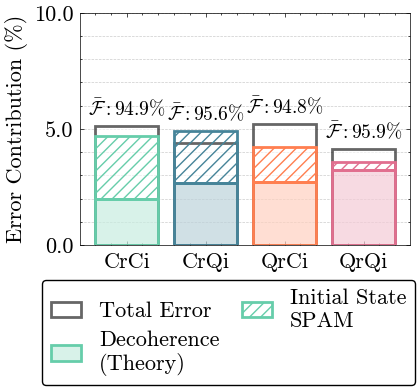

cq_err_breakdown_1protocol_202503270412
Saved svg plot s:\Connie\experiments\qram_tprocv1_expts\data_plot\cq_err_breakdown_1protocol_202503270412.svg
Saved pdf plot s:\Connie\experiments\qram_tprocv1_expts\data_plot\cq_err_breakdown_1protocol_202503270412.pdf


In [36]:
import matplotlib as mpl

darkmode = False
saveplot = True

plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use(mplstyle_path)
if darkmode: plt.style.use('dark_background')

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.grid(axis='y', which='both', color='k' if not darkmode else 'w', alpha=0.2)
cqs = ['CrCi', 'CrQi', 'QrCi', 'QrQi']
cq_labels = [latex_from_cq(cq) for cq in cqs]
colors_cq = [color_from_cq(cq) for cq in cqs]
rgbcolors_cq = [mcolors.to_rgb(c) for c in colors_cq]

use_ZZ_correction = True

bottom = np.zeros(len(cqs))

use_fid = get_fid_name(use_init_2q_state=False, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=True)
fids_id_global = np.array([CQ_fids_dict_processing_dict[use_fid][cq] for cq in cqs])
avg_fids_id_global = np.average(fids_id_global, axis=1)

use_fid = get_fid_name(use_init_2q_state=False, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=False)
fids_id_individual = np.array([CQ_fids_dict_processing_dict[use_fid][cq] for cq in cqs])

use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=True)
fids_meas_global = np.array([CQ_fids_dict_processing_dict[use_fid][cq] for cq in cqs])

use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=False)
fids_meas_individual = np.array([CQ_fids_dict_processing_dict[use_fid][cq] for cq in cqs])

label = "Total Error"
errs = 1 - avg_fids_id_global
print('TOTAL AVERAGE ERROR (%)', np.average(np.array(errs))*100, "FIDELITY (%)", 100*np.average(avg_fids_id_global))
ax.bar(cq_labels, errs, alpha=0.6, color='w' if not darkmode else 'k', edgecolor='k' if not darkmode else 'w', linewidth=2.0, linestyle='-', fill=True, label=label, bottom=np.zeros(len(cqs)), zorder=10)

label = "Decoherence\n(Theory)"
errs = [1 - fid_theory[cq] for cq in cqs]
print('decoherence errs (%)', 100*np.array(errs))
print('average decoherence errs (%)', np.average(np.array(errs))*100)
facecolors = [(*rgbcolors_cq[c], 0.25) for c in range(len(cqs))]
edgecolors = [(*rgbcolors_cq[c], 1.0) for c in range(len(cqs))]
ax.bar(cq_labels, errs, color=facecolors, edgecolor=edgecolors, linewidth=2.0, fill=True, label=label, bottom=bottom, zorder=10)
bottom += errs

label = "Timing Errors"
errs = np.abs(fids_id_individual - fids_id_global)
errs = np.average(errs, axis=1)
print('timing errs (%)', 100*errs)
print('average timing errs (%)', np.average(errs)*100)
facecolors = [(*rgbcolors_cq[c], 0.75) for c in range(len(cqs))]
edgecolors = [(*rgbcolors_cq[c], 1.0) for c in range(len(cqs))]

label = "Initial State\nSPAM"
errs = np.abs(fids_meas_individual - fids_id_individual)
errs = np.average(errs, axis=1)
print('spam errs (%)', errs*100)
print('average spam errs (%)', np.average(errs)*100)
facecolors = [(*rgbcolors_cq[c], 0.0) for c in range(len(cqs))]
edgecolors = [(*rgbcolors_cq[c], 1.0) for c in range(len(cqs))]
mpl.rcParams['hatch.linewidth'] = 1.0
ax.bar(cq_labels, errs, color=facecolors, edgecolor=edgecolors, linewidth=2.0, hatch='///', label=label, bottom=bottom, zorder=10)
bottom += errs

print('bottom', bottom)

# Labels for total error
labels = ["$\\bar{\\mathcal{F}}: $" + f"{fid:.3}%" for fid in 100*avg_fids_id_global]
rects = ax.patches
for i, (rect, label) in enumerate(zip(rects, labels)):
    height = max((1-avg_fids_id_global[i], bottom[i]))
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.003, label, ha="center", va="bottom", color='k' if not darkmode else 'w', fontsize=14
    )
overall_avg_fid = np.average(avg_fids_id_global)


ymin = 0.0
ymax = 0.1
ytick_spacing = 0.05
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
ax.set_yticks(ytick_labels, labels=100*ytick_labels) # scale y axis topercent
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.ylabel('Error Contribution (%)', fontsize=16)
plt.ylim(ymin, ymax)
plt.legend(bbox_to_anchor=(0.45, -0.1), loc='upper center', frameon=not darkmode, edgecolor='k', fontsize=16, ncol=2) # bbox is where to put box, loc is which corner of box is anchored

plt.show()

errs_grids_filepaths_str = fids_grids_filepaths[0][:12]
filename = f'cq_err_breakdown_1protocol_{errs_grids_filepaths_str}' + ('_dark' if darkmode else '')
print(filename)
if saveplot:
    savename = os.path.join(save_plot_path, filename+'.svg')
    fig.savefig(savename, bbox_inches='tight')
    print("Saved svg plot", savename)

    savename = os.path.join(save_plot_path, filename+'.pdf')
    fig.savefig(savename, bbox_inches='tight')
    print("Saved pdf plot", savename)

plt.show()
plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use(mplstyle_path)

### Fig. A7 errorbar charts for all states

spam errs (%) [2.71665297 2.21114784 1.49390839 0.37401969]
Saved svg plot s:\Connie\experiments\qram_tprocv1_expts\data_plot\cq_err_breakdown_1protocol_all_202503270412.svg
Saved pdf plot s:\Connie\experiments\qram_tprocv1_expts\data_plot\cq_err_breakdown_1protocol_all_202503270412.pdf


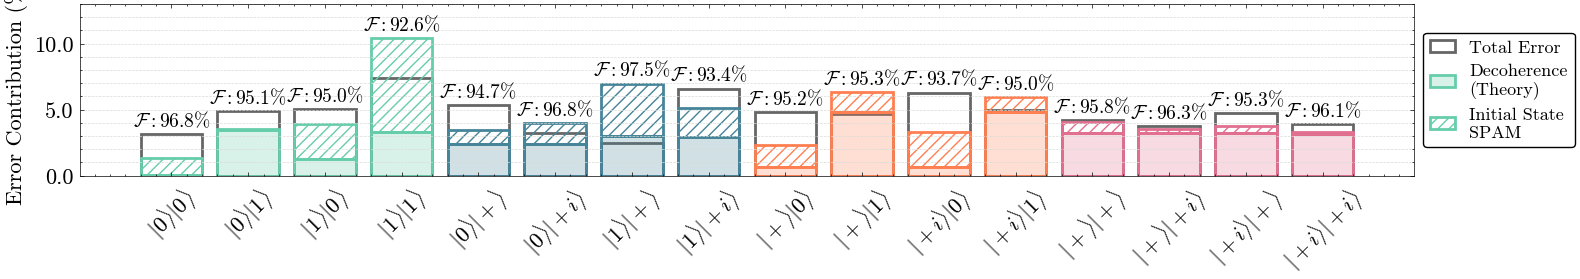

In [37]:
saveplot = True
use_ZZ_correction = True

use_fid = get_fid_name(use_init_2q_state=False, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=True)
fid_id = rho_qrams[0][use_fid]

use_fid = get_fid_name(use_init_2q_state=True, use_ZZ_correction=use_ZZ_correction, use_avg_opt_phis=True)
fid_meas = rho_qrams[0][use_fid]

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
plt.grid(axis='y', which='both')

labels = [key.replace('>', '\\rangle') for key in init_states]
labels = [label.replace('0+1', '+') for label in labels]
labels = [label.replace('0+i', '+i') for label in labels]

# add the r'' and $$
labels = [r'$' + label + '$' for label in labels]


errs_tot = [1 - fid_id[key] for key in init_states]
# errs_th = [1 - fid_th_all[key] for key in init_states]
errs_th = [1 -fid_theory_all_states[key] for key in init_states]
errs_spam = np.array([np.abs(fid_meas[key] - fid_id[key]) for key in init_states])
fid_id_array = np.array(list(fid_id.values()))
f_labels = ["${\\mathcal{F}}: $" + f"{fid:.3}%" for fid in 100*fid_id_array]

# reorder the labels/ init states and fidelity values to match the order of the cq_labels

cd_to_state = {}

for key in init_states:
    cd_to_state[key] = CQ_from_init(key)
    
cd_to_state_sorted = dict(sorted(cd_to_state.items(), key=lambda item: item[1]))
idx = [list(cd_to_state_sorted.keys()).index(key) for key in init_states]


# use idx to reorder the labels and the fids

labels = [labels[i] for i in idx]
f_labels = [f_labels[i] for i in idx]
errs_tot = [errs_tot[i] for i in idx]
errs_th = [errs_th[i] for i in idx]
errs_spam = [errs_spam[i] for i in idx]
fid_id_array = [fid_id_array[i] for i in idx]


# reorder the labels/ init states and fidelity values to match the order of the cq_labels

cd_to_state = {}

for key in init_states:
    cd_to_state[CQ_from_init(key)] = key



colors = []
for key in init_states:
    colors.append(mcolors.to_rgb(color_from_cq(CQ_from_init(key))))
    
colors = [colors[i] for i in idx]


label_tot = "Total Error"

ax.bar(labels, errs_tot, alpha=0.6, color='w', edgecolor='k', linewidth=2.0, linestyle='-', fill=True, bottom=np.zeros(len(labels)), label=label_tot)

# rotate the labels names
plt.xticks(rotation=45)

label_th = "Decoherence\n(Theory)"

facecolors = [(*colors[c], 0.25) for c in range(len(labels))]
edgecolors = [(*colors[c], 1.0) for c in range(len(labels))]
ax.bar(labels, errs_th,color=facecolors, edgecolor=edgecolors, linewidth=2.0, fill=True, bottom=np.zeros(len(labels)), label=label_th)
bottom = np.zeros(len(labels))
bottom += errs_th

label_spam = "Initial State\nSPAM"
print('spam errs (%)', errs*100)
facecolors = [(*colors[c], 0.0) for c in range(len(labels))]
edgecolors = [(*colors[c], 1.0) for c in range(len(labels))]
mpl.rcParams['hatch.linewidth'] = 1.0
ax.bar(labels, errs_spam, color=facecolors, edgecolor=edgecolors, linewidth=2.0, hatch='///', bottom=bottom, label=label_spam)
bottom += errs_spam


# Labels for total error
rects = ax.patches
for i, (rect, f_labels) in enumerate(zip(rects, f_labels)):
    height = max((1-fid_id_array[i], bottom[i]))
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.003, f_labels, ha="center", va="bottom", color='k', fontsize=14
    )


ymin = 0.0
ymax = 0.13
ytick_spacing = 0.05
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
ax.set_yticks(ytick_labels, labels=100*ytick_labels) # scale y axis to percent
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.ylabel('Error Contribution (%)', fontsize=16)
plt.ylim(ymin, ymax)
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', frameon=True, edgecolor='k', fontsize=13) # bbox is where to put box, loc is which corner of box is anchored
plt.tight_layout()


errs_grids_filepaths_str = fids_grids_filepaths[0][:12]
filename = f'cq_err_breakdown_1protocol_all_{errs_grids_filepaths_str}'
if saveplot:
    savename = os.path.join(save_plot_path, filename+'.svg')
    fig.savefig(savename, bbox_inches='tight')
    print("Saved svg plot", savename)

    savename = os.path.join(save_plot_path, filename+'.pdf')
    fig.savefig(savename, bbox_inches='tight')
    print("Saved pdf plot", savename)

plt.show()

## Fig. 4d decay of fidelity over number of protocols

In [38]:
use_init_2q_state = False # True->meas, False->ideal
use_ZZ_correction = True
use_avg_opt_phis = True # True->opt, False->individual

use_fid = get_fid_name(use_init_2q_state, use_ZZ_correction, use_avg_opt_phis)

In [39]:
x_sweep = [0, 1, 2, 3]

CQ_fids_dict_all_files = dict(
    CrCi=[], # average fid for each state in this category from all files
    CrQi=[],
    QrCi=[],
    QrQi=[],
)

init_states = rho_qrams[0][use_fid].keys()

for i_file, rho_qram in enumerate(rho_qrams):
    CQ_fids_dict = dict(
        CrCi=[], # fid for each state in this category from this file
        CrQi=[],
        QrCi=[],
        QrQi=[],
    )
    fids = rho_qram[use_fid] # dict: init_state -> fidelity for given number of protocols
    print(fids)
    for i, init_state in enumerate(init_states):
        cq = CQ_from_init(init_state)
        CQ_fids_dict[cq].append(fids[init_state])
        print(f"from file {i_file} adding fid {fids[init_state]} of {init_state} to {cq}")
    for cq in CQ_fids_dict.keys():
        # CQ_fids_dict_all_files[cq].append(np.average(CQ_fids_dict[cq]))
        CQ_fids_dict_all_files[cq].append(CQ_fids_dict[cq])

{'|0>|0>': 0.968345967910741, '|0>|1>': 0.9511662133537178, '|0>|0+1>': 0.9467829503084392, '|0>|0+i>': 0.9678572527765165, '|1>|0>': 0.9498376505424087, '|1>|1>': 0.9262605715871257, '|1>|0+1>': 0.9749759856630852, '|1>|0+i>': 0.9341313101721397, '|0+1>|0>': 0.9516963730761241, '|0+1>|1>': 0.9534090973348974, '|0+1>|0+1>': 0.9577834374453263, '|0+1>|0+i>': 0.9628026144145356, '|0+i>|0>': 0.9371744573762304, '|0+i>|1>': 0.9499675133860485, '|0+i>|0+1>': 0.9528425370556342, '|0+i>|0+i>': 0.9610776540968666}
from file 0 adding fid 0.968345967910741 of |0>|0> to CrCi
from file 0 adding fid 0.9511662133537178 of |0>|1> to CrCi
from file 0 adding fid 0.9467829503084392 of |0>|0+1> to CrQi
from file 0 adding fid 0.9678572527765165 of |0>|0+i> to CrQi
from file 0 adding fid 0.9498376505424087 of |1>|0> to CrCi
from file 0 adding fid 0.9262605715871257 of |1>|1> to CrCi
from file 0 adding fid 0.9749759856630852 of |1>|0+1> to CrQi
from file 0 adding fid 0.9341313101721397 of |1>|0+i> to CrQi
f

CrCi
fids_per_U [0.9489026  0.93427757 0.90771008 0.89533262 0.88182333 0.77197648]
avg_err_per_U 0.01648132739319952
CrQi
fids_per_U [0.95593687 0.87862149 0.84643863 0.85014318 0.81380425 0.68239653]
avg_err_per_U 0.025879973839016857
QrCi
fids_per_U [0.94806186 0.92256578 0.88620213 0.85646658 0.81150672 0.72994612]
avg_err_per_U 0.02353401907516084
QrQi
fids_per_U [0.95862656 0.90295711 0.84687487 0.82953811 0.7443978  0.6638961 ]
avg_err_per_U 0.03308866217471118
Average fidelity per U: 97.5254004379478 $\pm$ 0.4443802543332017
protocol_repeat_fidelity_ZZ_rotated_opt_vs_ideal_202503270412_202503270800_202503271149_202503271538_202503271928_202503272318
Saved svg plot s:\Connie\experiments\qram_tprocv1_expts\data_plot\protocol_repeat_fidelity_ZZ_rotated_opt_vs_ideal_202503270412_202503270800_202503271149_202503271538_202503271928_202503272318.svg
Saved pdf plot s:\Connie\experiments\qram_tprocv1_expts\data_plot\protocol_repeat_fidelity_ZZ_rotated_opt_vs_ideal_202503270412_202503270

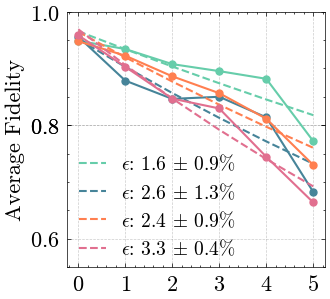

In [40]:
darkmode = False
saveplot = True

plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use(mplstyle_path)
if darkmode: plt.style.use('dark_background')

figsize = (3.5, 3.2)
# fig, ax = plt.subplots(1, 1, figsize=(5, 3))
fig, ax = plt.subplots(1, 1, figsize=figsize)
plt.grid(color='k' if not darkmode else 'w', alpha=0.2)

def fit_func(depth, p, a):
    return a * p**depth

avg_err_per_U_cqs = []
avg_err_per_U_err_cqs = []

for cq in CQ_fids_dict_all_files.keys():
    print(cq)
    fids_per_U_all_cq = CQ_fids_dict_all_files[cq] # shape: n_files x n_states_per_cq
    fids_per_U = np.average(fids_per_U_all_cq, axis=1)

    plt.plot(range(len(fids_per_U)), fids_per_U, 'o-', color=color_from_cq(cq), markersize=5)

    # --- Get error by fit --- 
    n_fit_plot = 1 + 2*np.arange(0, len(fids_per_U))
    n_fit = np.repeat(n_fit_plot, np.array(fids_per_U_all_cq).shape[1]).flatten()
    x_plot = np.arange(0, len(fids_per_U))

    p, pcov = sp.optimize.curve_fit(fit_func, n_fit, np.array(fids_per_U_all_cq).flatten())
    avg_err_per_U = 1 - p[0]
    avg_err_per_U_err = np.sqrt(pcov[0, 0])
    avg_err_per_U_cqs.append(avg_err_per_U)
    avg_err_per_U_err_cqs.append(avg_err_per_U_err)

    print("fids_per_U", fids_per_U)
    print("avg_err_per_U", avg_err_per_U)

    plt.plot(x_plot, fit_func(n_fit_plot, *p), '--', label="$\epsilon$: "+f"{np.round(avg_err_per_U*100, 1):.2} $\pm$ {ceil_decimal(z*avg_err_per_U_err*100, 1):.2}%", color=color_from_cq(cq), markersize=5)

avg_err_err_avg = np.sqrt(np.sum(np.array(avg_err_per_U_err_cqs)**2)) / len(avg_err_per_U_err_cqs)
print(f"Average fidelity per U: {100*(1 - np.average(avg_err_per_U_cqs))} $\pm$ {100*z*np.average(avg_err_err_avg)}")

ax.set_xticks(range(len(fids_per_U)))
ymin = 0.55
ymax = 1.0
ytick_spacing = 0.2
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
ax.set_yticks(ytick_labels)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Average Fidelity', fontsize=16)
plt.ylim(ymin, ymax)
plt.legend(fontsize=14, loc="lower left", bbox_to_anchor=(-0.02, -0.035), frameon=False) #frameon=True, framealpha=0.5)
plt.tight_layout()

fids_grids_filepaths_str = '_'.join([fids_grids_filepath[:12] for fids_grids_filepath in fids_grids_filepaths])
filename = f'protocol_repeat_{use_fid}_{fids_grids_filepaths_str}' + ('_dark' if darkmode else '')
print(filename)

if saveplot:
    savename = os.path.join(save_plot_path, filename+'.svg')
    fig.savefig(savename, bbox_inches='tight')
    print("Saved svg plot", savename)

    savename = os.path.join(save_plot_path, filename+'.pdf')
    fig.savefig(savename, bbox_inches='tight')
    print("Saved pdf plot", savename)

plt.show()
plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use(mplstyle_path)

# Tomography plots

## Fig. 4b

In [41]:
filepaths_str = fids_grids_filepaths[0][:12] # to name the saved plot file based on the data file used

In [42]:
use_init_2q_state = False # True->meas, False->ideal
use_ZZ_correction = True
use_avg_opt_phis = True # True->opt, False->individual

use_fid = get_fid_name(use_init_2q_state, use_ZZ_correction, use_avg_opt_phis)
use_rho = get_rho_name(use_ZZ_correction, rotated=True, use_init_2q_state=use_init_2q_state, use_avg_opt_phis=use_avg_opt_phis)

0plus1-0plusi
Measured fidelity 0.9628026144145356
Saved s:\Connie\experiments\qram_tprocv1_expts\data_plot\tomo_3q_0plus1-0plusi_202503270412.svg


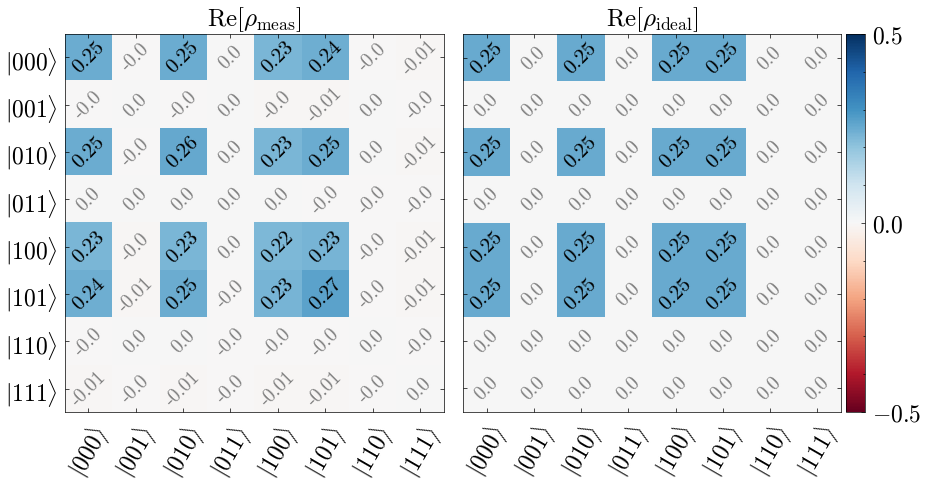

In [43]:
init_state = "|0+1>|0+i>"
init_state_title = "|+\\rangle|i\\rangle"
init_state_savename = init_state.replace(">|", "-")
init_state_savename = init_state_savename.replace("|", "")
init_state_savename = init_state_savename.replace(">", "")
init_state_savename = init_state_savename.replace("+", "plus")
print(init_state_savename)

rho_meas_3q = rho_qrams[0][use_rho][init_state]
print("Measured fidelity", rho_qrams[0][use_fid][init_state])
rho_id_2q = qt.ket2dm(name_to_state_2q(init_state)).full()
rho_id_3q = get_qram_qSLR_state_from_rho(rho_id_2q)

rho_test = rho_meas_3q.full() if isinstance(rho_meas_3q, qt.Qobj) else rho_meas_3q
rho_id = rho_id_3q.full() if isinstance(rho_id_3q, qt.Qobj) else rho_id_3q

tomo_analysis = TomoAnalysis(3)

title=f"Initial State: ${init_state_title}$"
labels = [f"$|{state}\\rangle$" for state in tomo_analysis.calib_order_numeric]
tick_rotation = 60
ideal_name = "ideal"

width = 10.0
height = 5
size = (width, height)
cmax = 0.5

fig, axes = plt.subplots(1, 2, figsize=size, gridspec_kw={"width_ratios": [1, 1.06]})
left = 0.1
wspace = 0.05
plt.subplots_adjust(left=left, right=1-left, wspace=wspace, hspace=wspace/1.0) 
# plt.suptitle(title, fontsize=18, y=1.05)
ax1 = axes[0]
ax2 = axes[1]
tomo_analysis.show_mat_2d(
    np.real(rho_test),
    ax=ax1,
    title="Re[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)

tomo_analysis.show_mat_2d(
    np.real(rho_id),
    ax=ax2,
    title="Re[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)

# plt.tight_layout()
filename = f'tomo_3q_{init_state_savename}_{filepaths_str}'
savename = os.path.join(save_plot_path, filename+'.svg')
plt.savefig(savename, bbox_inches="tight", transparent=True)
print("Saved", savename)

plt.show()


## Fig. A8a

In [44]:
filepaths_str = fids_grids_filepaths[0][:12] # to name the saved plot file based on the data file used

In [45]:
use_init_2q_state = False # True->meas, False->ideal
use_ZZ_correction = True
use_avg_opt_phis = True # True->opt, False->individual

use_fid = get_fid_name(use_init_2q_state, use_ZZ_correction, use_avg_opt_phis)
use_rho = get_rho_name(use_ZZ_correction, rotated=True, use_init_2q_state=use_init_2q_state, use_avg_opt_phis=use_avg_opt_phis)

In [46]:
init_state = "|0+1>|1>"

init_state_title = ""
for c in init_state:
    if c != ">": init_state_title += c
    else: init_state_title += "\\rangle"

0plus1-1
Saved s:\Connie\experiments\qram_tprocv1_expts\data_plot\tomo_2q_0plus1-1_202503270412.svg


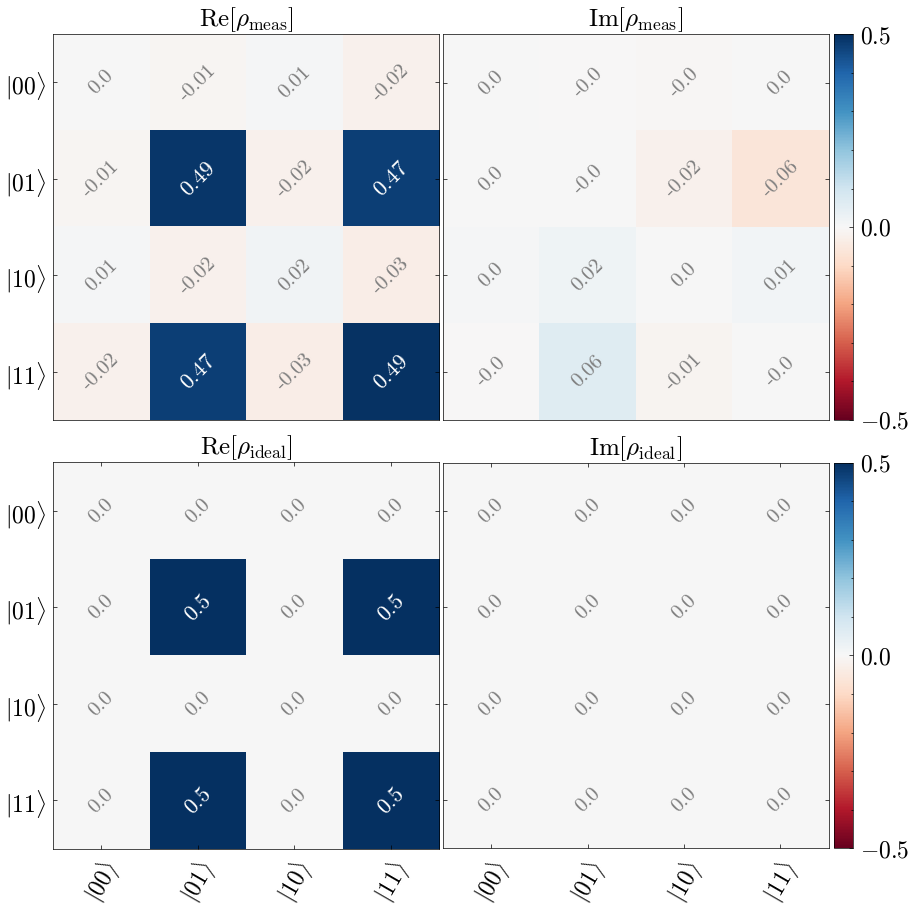

In [47]:
darkmode = False

plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use(mplstyle_path)
if darkmode: plt.style.use('dark_background')

tomo_analysis = TomoAnalysis(2)
rho_meas_2q = rho_MLE_ZZ_dict[init_state]
rho_id_2q = qt.ket2dm(name_to_state_2q(init_state)).full()

init_state_savename = init_state.replace(">|", "-")
init_state_savename = init_state_savename.replace("|", "")
init_state_savename = init_state_savename.replace(">", "")
init_state_savename = init_state_savename.replace("+", "plus")
print(init_state_savename)
filename = f'supmat\\tomo_2q_{init_state_savename}_{filepaths_str}'
savename = os.path.join(save_plot_path, filename+'.svg')

rho_test = rho_meas_2q
rho_id = rho_id_2q
labels = [f"$|{state}\\rangle$" for state in tomo_analysis.calib_order_numeric]
tick_rotation = 60
ideal_name = "ideal"

width = 10.0
height = 11.0
size = (width, height)
cmax = 0.5

fig, axes = plt.subplots(2, 2, figsize=size, gridspec_kw={"width_ratios": [1, 1.06], "height_ratios":[1, 1]})
left = 0.1
wspace = 0.01
plt.subplots_adjust(left=left, right=1-left, wspace=wspace, hspace=wspace/1.0) 
# plt.suptitle(title, fontsize=18, y=1.05)
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]
tomo_analysis.show_mat_2d(
    np.real(rho_test),
    ax=ax1,
    title="Re[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_xticks=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.imag(rho_test),
    ax=ax2,
    title="Im[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_xticks=False,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.real(rho_id),
    ax=ax3,
    title="Re[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.imag(rho_id),
    ax=ax4,
    title="Im[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)

filename = f'tomo_2q_{init_state_savename}_{filepaths_str}' + ('_dark' if darkmode else '') 
savename = os.path.join(save_plot_path, filename+'.svg')
plt.savefig(savename, bbox_inches="tight", transparent=True)
print("Saved", savename)

plt.show()

plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use(mplstyle_path)

## Fig. A8b

fidelity 0.9534090973348974 use_fid fidelity_ZZ_rotated_opt_vs_ideal
0plus1-1
Saved s:\Connie\experiments\qram_tprocv1_expts\data_plot\tomo_3q_0plus1-1_202503270412.svg


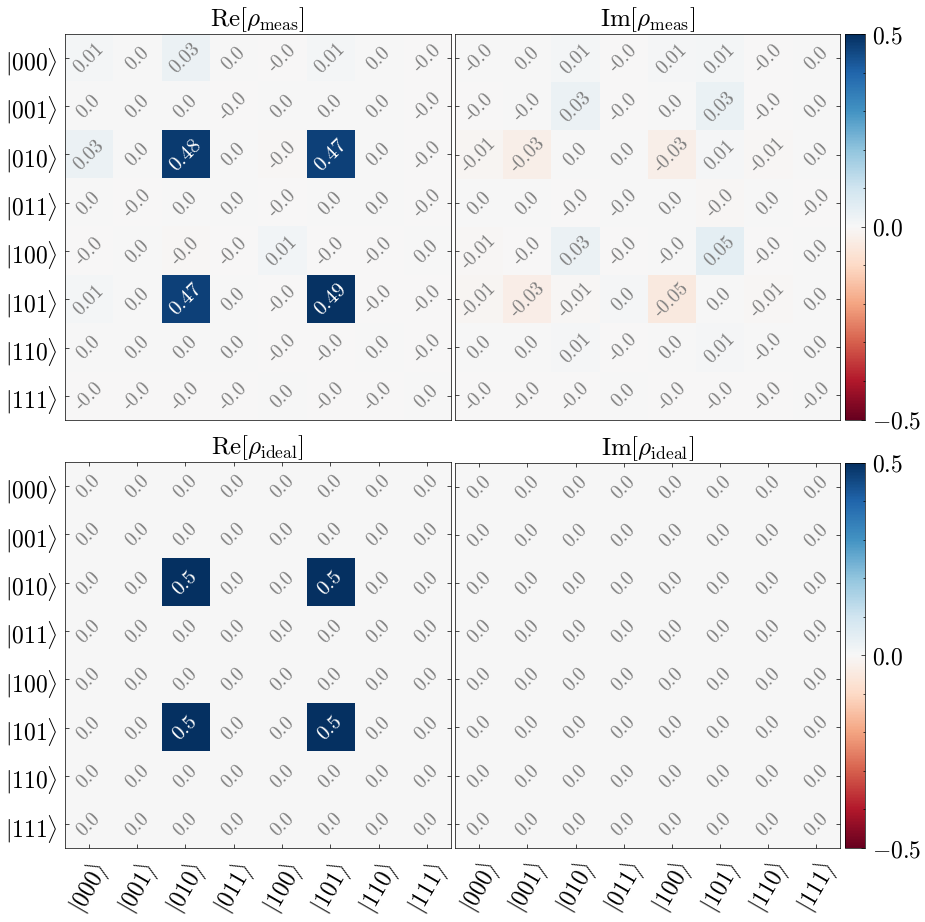

In [49]:
darkmode = False

plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use(mplstyle_path)
if darkmode: plt.style.use('dark_background')

rho_meas_3q = rho_qrams[0][use_rho][init_state]
fid = rho_qrams[0][use_fid][init_state]
print("fidelity", fid, "use_fid", use_fid)
rho_id_2q = qt.ket2dm(name_to_state_2q(init_state)).full()
rho_id_3q = get_qram_qSLR_state_from_rho(rho_meas_2q)

tomo_analysis = TomoAnalysis(3)

filepaths_str = fids_grids_filepaths[0][:12]
init_state_savename = init_state.replace(">|", "-")
init_state_savename = init_state_savename.replace("|", "")
init_state_savename = init_state_savename.replace(">", "")
init_state_savename = init_state_savename.replace("+", "plus")
print(init_state_savename)

rho_id = rho_id_3q if use_init_2q_state else get_qram_qSLR_state_from_rho(rho_id_2q)
rho_test = rho_meas_3q.full() if isinstance(rho_meas_3q, qt.Qobj) else rho_meas_3q
rho_id = rho_id.full() if isinstance(rho_id, qt.Qobj) else rho_id
labels = [f"$|{state}\\rangle$" for state in tomo_analysis.calib_order_numeric]
tick_rotation = 60
ideal_name = "target" if use_init_2q_state else "ideal"

width = 10.0
height = 11.0
size = (width, height)
cmax = 0.5

fig, axes = plt.subplots(2, 2, figsize=size, gridspec_kw={"width_ratios": [1, 1.06], "height_ratios":[1, 1]})
left = 0.1
wspace = 0.01
plt.subplots_adjust(left=left, right=1-left, wspace=wspace, hspace=wspace/1.0) 
# plt.suptitle(title, fontsize=18, y=1.05)
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

tomo_analysis.show_mat_2d(
    np.real(rho_test),
    ax=ax1,
    title="Re[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_xticks=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.imag(rho_test),
    ax=ax2,
    title="Im[$\\rho_{\\mathrm{meas}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_xticks=False,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.real(rho_id),
    ax=ax3,
    title="Re[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=False,
    show_yticks=True,
    show=False,
    tick_rotation=tick_rotation,
)
tomo_analysis.show_mat_2d(
    np.imag(rho_id),
    ax=ax4,
    title="Im[$\\rho_{\\mathrm{" + ideal_name + "}}$]",
    labels=labels,
    cmax=cmax,
    show_cbar=True,
    show_yticks=False,
    show=False,
    tick_rotation=tick_rotation,
)

filename = f'tomo_3q_{init_state_savename}_{filepaths_str}' + ('_dark' if darkmode else '') 
savename = os.path.join(save_plot_path, filename+'.svg')
plt.savefig(savename, bbox_inches="tight", transparent=False)
print("Saved", savename)

plt.show()

plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use(mplstyle_path)